<center><h1>Gude_Neel_HW5</h1></center>
<br>
<br>

Name: Neel Gude
<br>
Github Username: NPG1103 
<br>
USC ID: 7948367922

## 1. Decision Trees as Interpretable Models

Import packages

In [463]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm

from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression , RidgeCV , LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import _tree, DecisionTreeClassifier
from sklearn.datasets import load_iris
import xgboost as xgb

### (a) Obtain Data

Get the Accute Inamations Data Set

In [238]:
path = r'C:\Users\neelg\Downloads\diagnosis.data'
column_name = ["Temperature", "Nausea", "Lumbar", "Urine","Micturition", "Urethra", "Inflammation", "Nephritis"]
feature_names = ["Temp of patient", "Occurrence of nausea", "Lumbar pain", "Urine pushing", "Micturition pains", "Burning of urethra"]
target_names = ["Inflammation of urinary bladder", "Nephritis of renal pelvis origin"]
df = pd.read_csv(path, names=clmn_name, encoding='utf-16', sep='\t', decimal=",")
df.head()

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


### (b) Build a decision tree

C:\Users\neelg\AppData\Local\Temp\ipykernel_18748\230269164.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'yes': 1, 'no': 0}, inplace=True)


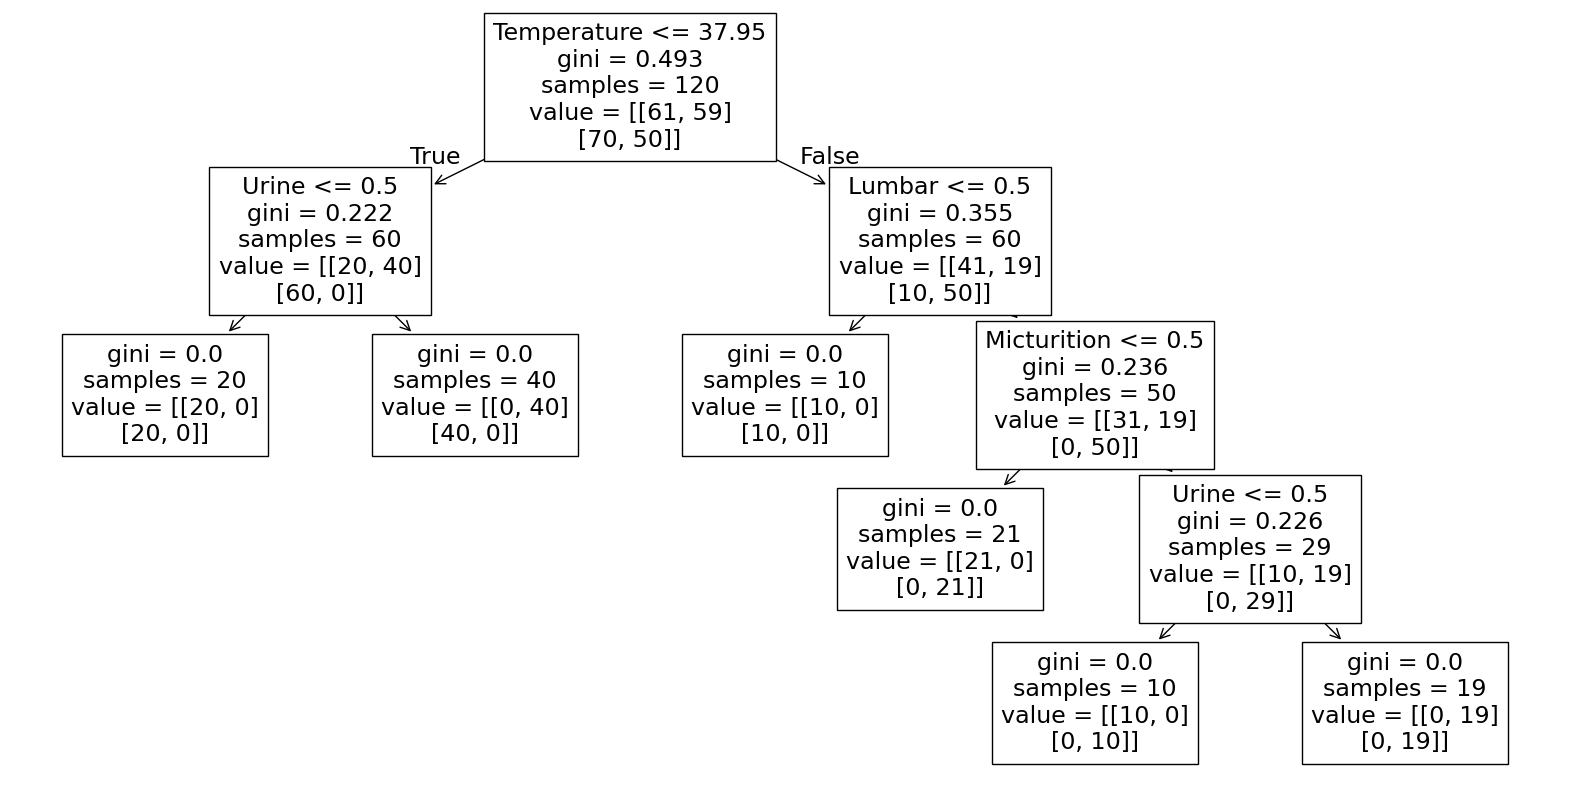

In [240]:
df.replace({'yes': 1, 'no': 0}, inplace=True)

X = df.iloc[:, :-2]
y = df.iloc[:, -2:]

model = DecisionTreeClassifier(random_state=50)
model.fit(X, y)
plt.figure(figsize=(20,10))
tree.plot_tree(model, feature_names=feature_name, class_names=class_name)
plt.show()

### (c) Convert the decision rules

In [250]:
def get_rules(tree, feature_names, target_names, node_index=0, depth=0):
    if tree.feature[node_index] != -2:
        name = feature_names[tree.feature[node_index]]
        threshold = tree.threshold[node_index]
        yield f'{"|   " * depth}if {name} <= {threshold:.2f}:'
        yield from get_rules(tree, feature_names, target_names, tree.children_left[node_index], depth + 1)
        yield f'{"|   " * depth}else:  # if {name} > {threshold:.2f}'
        yield from get_rules(tree, feature_names, target_names, tree.children_right[node_index], depth + 1)
    else:
        target = target_names[tree.value[node_index].argmax()]
        yield f'{"|   " * depth}return {target}'

rules = list(get_rules(model.tree_, feature_names, target_names))
for rule in rules:
    print(rule)

if Temp of patient <= 37.95:
|   if Urine pushing <= 0.50:
|   |   return Inflammation of urinary bladder
|   else:  # if Urine pushing > 0.50
|   |   return Nephritis of renal pelvis origin
else:  # if Temp of patient > 37.95
|   if Lumbar pain <= 0.50:
|   |   return Inflammation of urinary bladder
|   else:  # if Lumbar pain > 0.50
|   |   if Micturition pains <= 0.50:
|   |   |   return Inflammation of urinary bladder
|   |   else:  # if Micturition pains > 0.50
|   |   |   if Urine pushing <= 0.50:
|   |   |   |   return Inflammation of urinary bladder
|   |   |   else:  # if Urine pushing > 0.50
|   |   |   |   return Nephritis of renal pelvis origin


### (d) Cost-complexity 

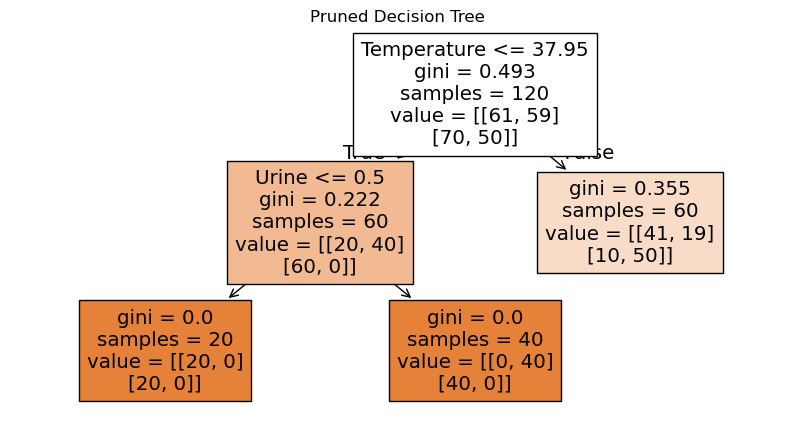

|--- Temperature <= 37.95
|   |--- Urine <= 0.50
|   |   |--- class: 0
|   |--- Urine >  0.50
|   |   |--- class: 1
|--- Temperature >  37.95
|   |--- class: 0



In [258]:
path = model.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

models = [DecisionTreeClassifier(random_state=0, ccp_alpha=alpha).fit(X, y) 
        for alpha in ccp_alphas]

pruned_model = models[-3]

plt.figure(figsize=(10,5))
plot_tree(pruned_model, feature_names=X.columns, class_names=["No", "Yes"], filled=True)
plt.title("Pruned Decision Tree")
plt.show()

pruned_rules = export_text(pruned_model, feature_names=list(X.columns))
print(pruned_rules)


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [373]:
path = r'C:\Users\neelg\Downloads\communities.data'
columns = ['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop' ]
df = pd.read_csv(path, header=None, na_values='?')
df.columns = columns
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [375]:
df = df.drop(columns=['state','county','community','communityname','fold'])
training_set = df.iloc[:1495, :]
testing_set = df.iloc[1495:, :]

### (b) Missing values

In [377]:
imputer = df.columns[df.isnull().any()]
for i in imputer:
    df[i].fillna(df[i].mean(), inplace=True)
df

C:\Users\neelg\AppData\Local\Temp\ipykernel_18748\3811871426.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].fillna(df[i].mean(), inplace=True)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


### (c) Plot a correlation matrix

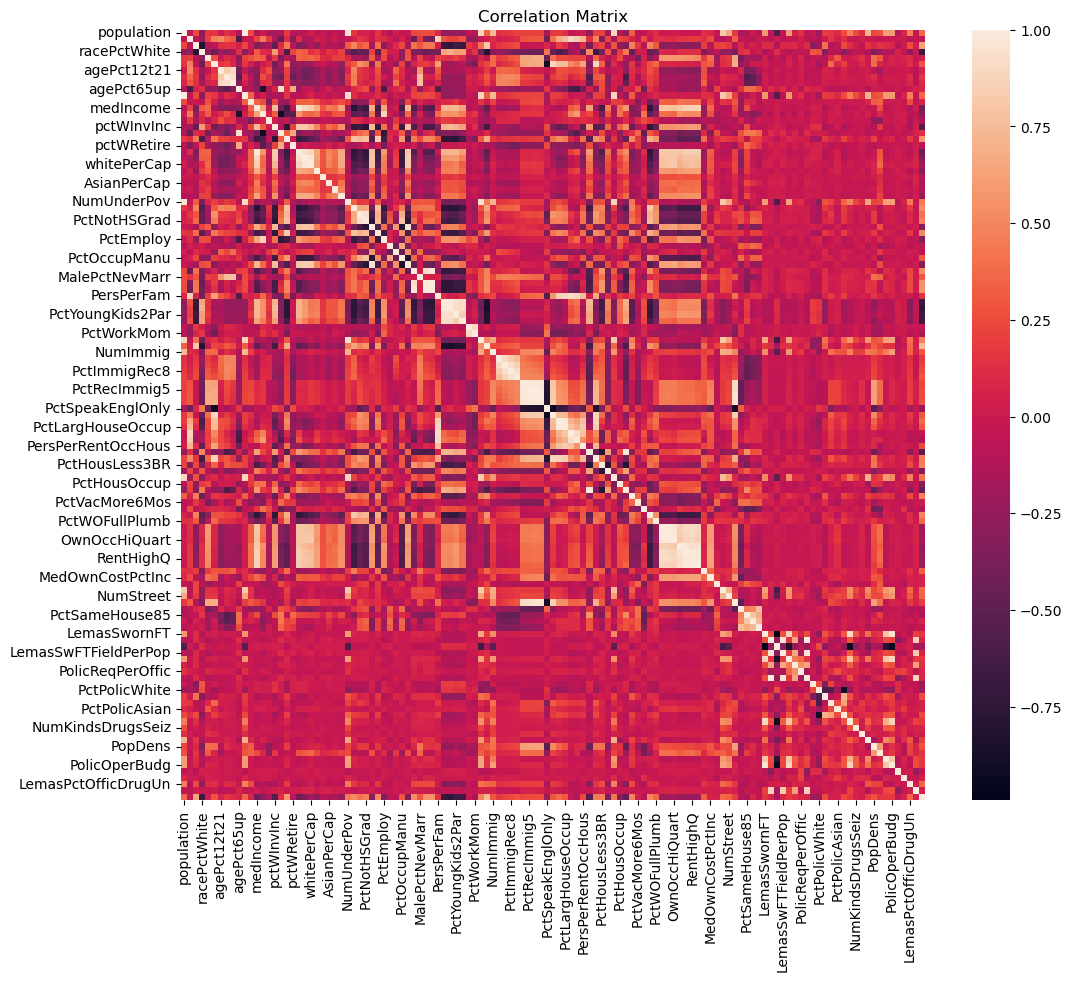

In [379]:
plt.figure(figsize=(12, 10))
sb.heatmap(df.corr())
plt.title("Correlation Matrix")
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [407]:
std = df.describe().loc['std']
mean = df.describe().loc['mean']
cv = std/mean
cv_df = pd.DataFrame({'Feature' : cv.index, 'CV': cv.values})
cv_df

,Feature,CV
0,population,2.203503
1,householdsize,0.353298
2,racepctblack,1.410920
3,racePctWhite,0.323782
4,racePctAsian,1.359162
...,...,...
118,LemasPctPolicOnPatr,0.122331
119,LemasGangUnitDeploy,0.368040
120,LemasPctOfficDrugUn,2.555266
121,PolicBudgPerPop,0.337281


### (e) Scatter plots and box plots for highest CV features

In [423]:
cv_sorted = cv.sort_values(ascending=False)
sum_features = int(math.sqrt(128))
top_features = cv_sorted.head(sum_features)
top_features

NumStreet              4.407702
NumInShelters          3.485481
NumIlleg               2.994196
NumImmig               2.900497
LemasPctOfficDrugUn    2.555266
NumUnderPov            2.304970
population             2.203503
numbUrban              2.001744
HousVacant             1.958780
LandArea               1.678031
racePctHisp            1.614278
dtype: float64

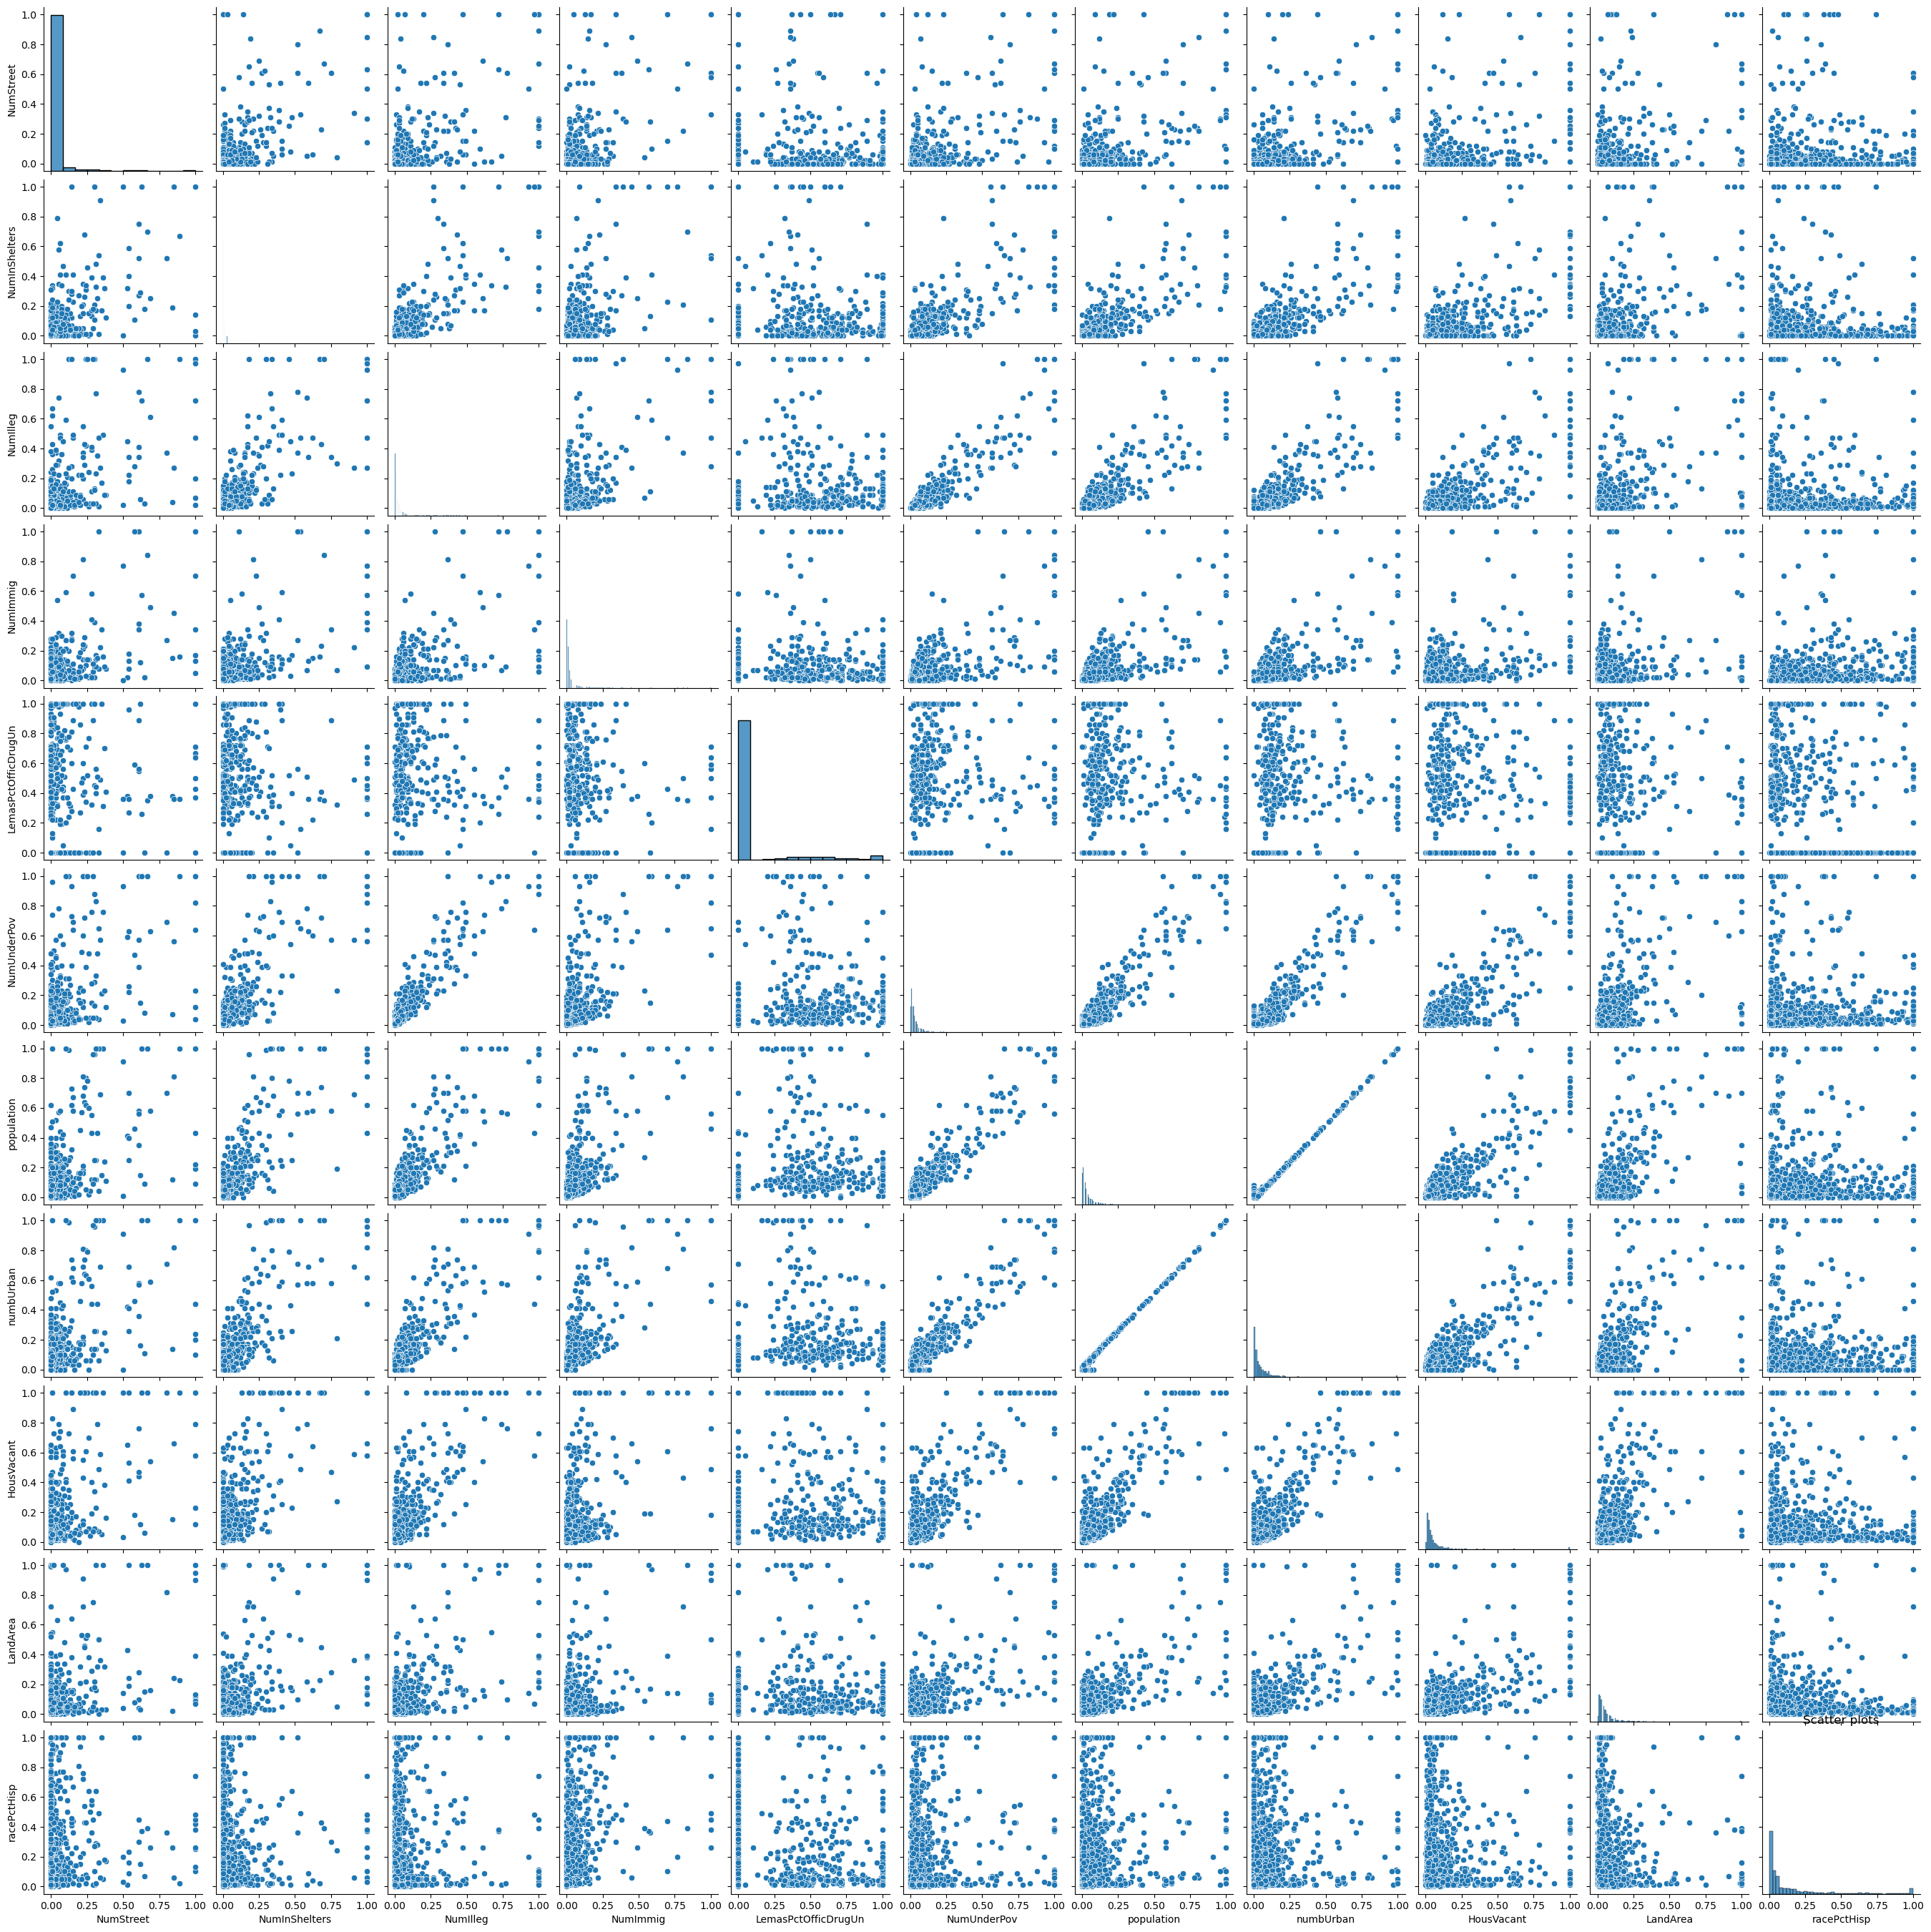

In [427]:
sb.pairplot(df[top_features.index])
plt.title("Scatter plots")
plt.show()

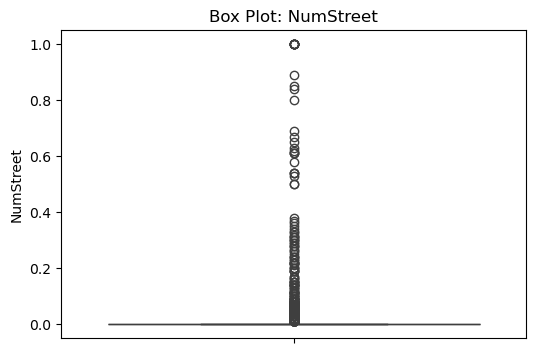

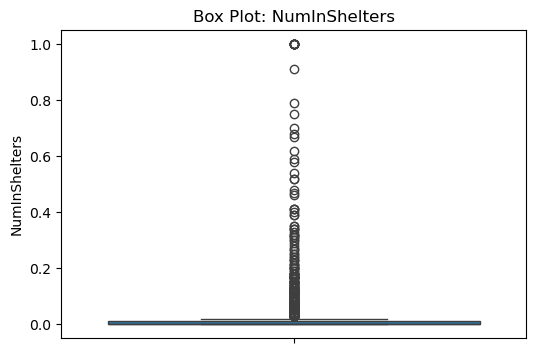

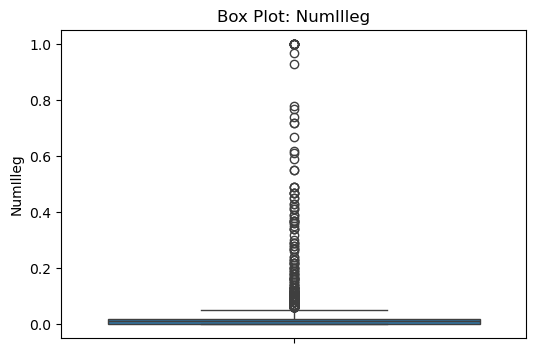

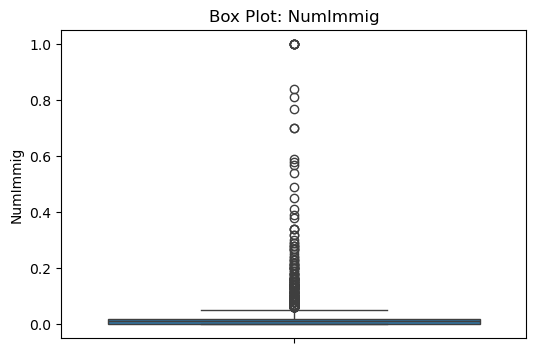

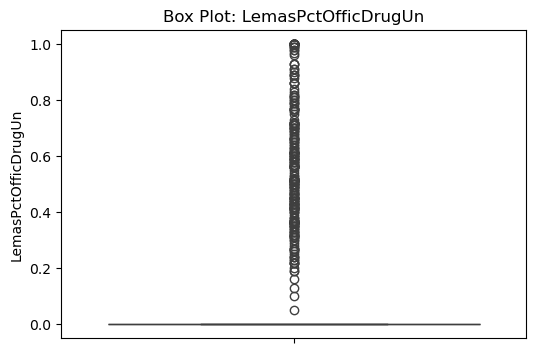

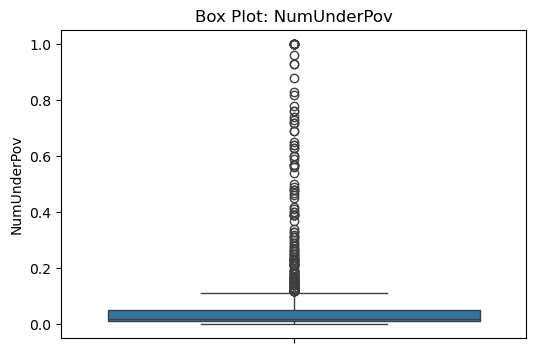

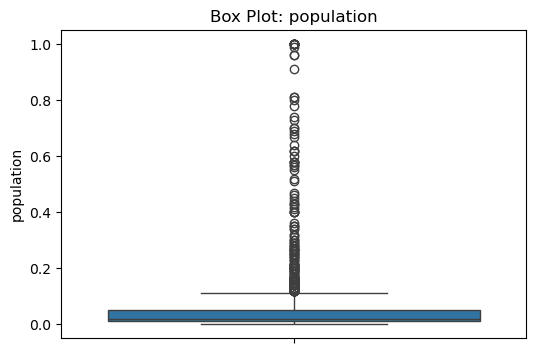

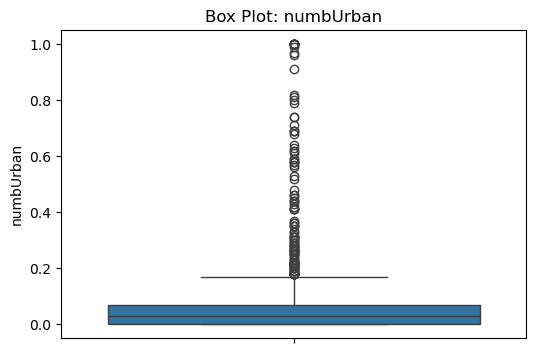

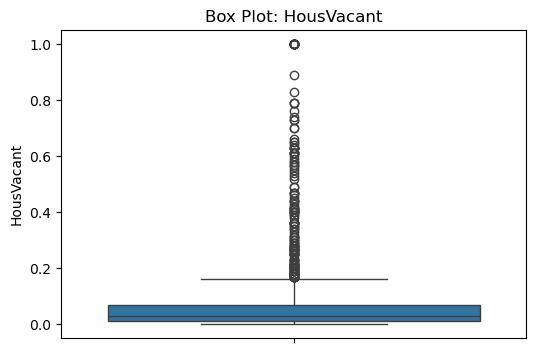

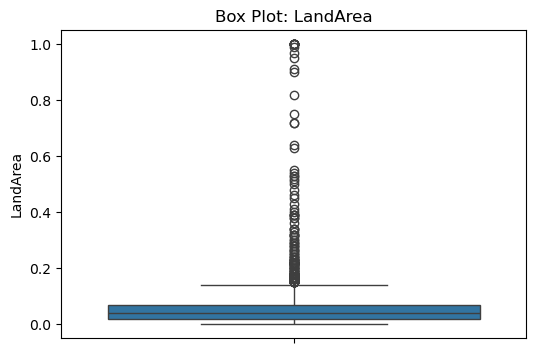

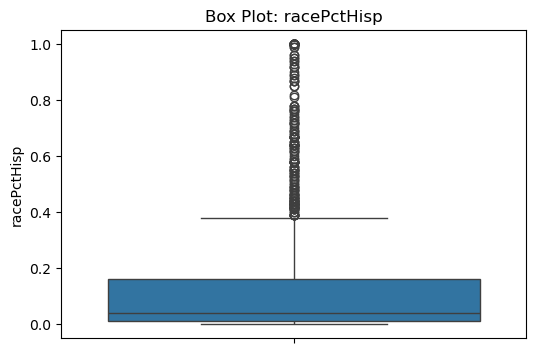

In [435]:
for i in top_features.index:
    plt.figure(figsize=(6, 4))
    sb.boxplot(y=df[i])
    plt.title(f'Box Plot: {i}')
    plt.show()

**Just by the Scatter Plots we cannot come to a conclusion for the top CV features**

### (f) Fit a linear model

In [440]:
X_train = training_set.iloc[:, :-1]
y_train = training_set.iloc[:, -1:]

X_test = testing_set.iloc[:, :-1]
y_test = testing_set.iloc[:, -1:]

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)
test_error_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Test Error (Linear Regression): {test_error_linear}")

Test Error (Linear Regression): 0.7897255274396451


### (g) Fit a ridge regression model

In [442]:
alphas = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

y_pred_ridge = ridge_cv.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Best lambda (alpha):", ridge_cv.alpha_)
print("Ridge Regression Test MSE:", mse_ridge)

Best lambda (alpha): 2.1544346900318843
Ridge Regression Test MSE: 0.01761367381193144


### (h) Fit a LASSO model

In [452]:
lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_train, y_train.values.ravel())
y_pred = lasso_model.predict(X_test)

#opt_alpha_lasso = lasso_model.alpha_
test_error_lasso = mean_squared_error(y_test, y_pred)
print("Selected Features (Without Standardization):\n")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")
print("\nLASSO Test MSE (Without Standardization): {:.5f}".format(test_error_lasso))

Selected Features (Without Standardization):

1. racepctblack
2. racePctAsian
3. agePct12t21
4. agePct12t29
5. pctUrban
6. pctWWage
7. pctWFarmSelf
8. pctWInvInc
9. pctWSocSec
10. pctWPubAsst
11. pctWRetire
12. whitePerCap
13. blackPerCap
14. indianPerCap
15. AsianPerCap
16. OtherPerCap
17. HispPerCap
18. PctPopUnderPov
19. PctLess9thGrade
20. PctEmploy
21. PctEmplManu
22. PctOccupManu
23. MalePctDivorce
24. MalePctNevMarr
25. FemalePctDiv
26. PctKids2Par
27. PctYoungKids2Par
28. PctTeen2Par
29. PctWorkMom
30. NumIlleg
31. PctIlleg
32. NumImmig
33. PctImmigRec10
34. PctRecImmig10
35. PctNotSpeakEnglWell
36. PctLargHouseOccup
37. PersPerOccupHous
38. PctPersOwnOccup
39. PctPersDenseHous
40. PctHousLess3BR
41. MedNumBR
42. HousVacant
43. PctHousOccup
44. PctVacantBoarded
45. PctVacMore6Mos
46. MedYrHousBuilt
47. PctHousNoPhone
48. PctWOFullPlumb
49. OwnOccLowQuart
50. RentLowQ
51. MedRent
52. MedRentPctHousInc
53. MedOwnCostPctInc
54. MedOwnCostPctIncNoMtg
55. NumInShelters
56. NumStreet

In [458]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_model_std = LassoCV(alphas=alphas, cv=5)
lasso_model_std.fit(X_train_scaled, y_train.values.ravel())
y_pred_std = lasso_model_std.predict(X_test_scaled)

#opt_alpha_lasso = lasso_model.alpha_
test_error_lasso_std = mean_squared_error(y_test, y_pred_std)
print("Selected Features (With Standardization):\n")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")
print("\nLASSO Test MSE (With Standardization): {:.5f}".format(test_error_lasso_std))

Selected Features (With Standardization):

1. racepctblack
2. racePctAsian
3. agePct12t21
4. agePct12t29
5. pctUrban
6. pctWWage
7. pctWFarmSelf
8. pctWInvInc
9. pctWSocSec
10. pctWPubAsst
11. pctWRetire
12. whitePerCap
13. blackPerCap
14. indianPerCap
15. AsianPerCap
16. OtherPerCap
17. HispPerCap
18. PctPopUnderPov
19. PctLess9thGrade
20. PctEmploy
21. PctEmplManu
22. PctOccupManu
23. MalePctDivorce
24. MalePctNevMarr
25. FemalePctDiv
26. PctKids2Par
27. PctYoungKids2Par
28. PctTeen2Par
29. PctWorkMom
30. NumIlleg
31. PctIlleg
32. NumImmig
33. PctImmigRec10
34. PctRecImmig10
35. PctNotSpeakEnglWell
36. PctLargHouseOccup
37. PersPerOccupHous
38. PctPersOwnOccup
39. PctPersDenseHous
40. PctHousLess3BR
41. MedNumBR
42. HousVacant
43. PctHousOccup
44. PctVacantBoarded
45. PctVacMore6Mos
46. MedYrHousBuilt
47. PctHousNoPhone
48. PctWOFullPlumb
49. OwnOccLowQuart
50. RentLowQ
51. MedRent
52. MedRentPctHousInc
53. MedOwnCostPctInc
54. MedOwnCostPctIncNoMtg
55. NumInShelters
56. NumStreet
57

**The Lasso Test MSE with and without standardization is similar**

### (i) Fit a PCR model

In [461]:
scaler_pcr = StandardScaler()
X_train_scaled = scaler_pcr.fit_transform(X_train)
X_test_scaled = scaler_pcr.transform(X_test)

mse_list = []
components = np.arange(1, X_train.shape[1]+1)

for m in components:
    pca = PCA(n_components=m)
    X_train_pca = pca.fit_transform(X_train_scaled)
    scores = cross_val_score(LinearRegression(), X_train_pca, y_train, scoring='neg_mean_squared_error', cv=5)
    mse_list.append(-scores.mean())

best_m = components[np.argmin(mse_list)]
print("Optimal number of components (M):", best_m)

pca = PCA(n_components=best_m)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model_pcr = LinearRegression()
model_pcr.fit(X_train_pca, y_train)
y_pred_pcr = model_pcr.predict(X_test_pca)
mse_pcr = mean_squared_error(y_test, y_pred_pcr)
print("PCR Test MSE:", mse_pcr)

Optimal number of components (M): 95
PCR Test MSE: 0.01839596749102057


### (j) Fit a boosting tree

In [470]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

param_grid = {'alpha': list(range(0, 12))}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', reg_alpha=0)

grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_['alpha'])

best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("Boosting Tree Test MSE:", mse_xgb)

Best alpha: 0
Boosting Tree Test MSE: 0.01913544818056787


In [476]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=0.1).fit(X_train, y_train)
test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("XGBoost model's test MSE:", test_mse)

XGBoost model's test MSE: 0.01754528781156862


**REFERENCES**
1. http://scikit-learn.org/stable/modules/tree.html
2. https://scikit-learn.org/stable/modules/impute.html
3. https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
6. 